In [1]:
#Import all the necessary libraries for further use
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')



Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.22.0               |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.22.0-pyh9f0ad1d_0



geopy-1.22.0         | 63 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: 

In [2]:

#To get the dataset from FourSquare API
import pandas as pd
import json, requests
from pandas.io.json import json_normalize
explore = 'https://api.foursquare.com/v2/venues/explore'
client_id='H1Z02MMDPZ2JOXFSIKZGGZA42KCFR4ZTNCBV0WYZOXKDXO3V'
client_secret='AHTSKX4DZDW5CPHBCGSSQCGMXXWABNZRU1ZPEJSTNGDDFULU'
params = dict(
client_id=client_id,
client_secret=client_secret,
v='20200429',
near= 'New York, NY',#ll='40.7128,-74.0060',
query='food',
limit=2000,
radius=100000
)
resp = requests.get(url=explore, params=params)
data = json.loads(resp.text)
venues = data['response']['groups'][0]['items']
df = pd.json_normalize(venues)
dtst=df[['venue.id','venue.name','venue.location.lat','venue.location.lng']]
dtst
x=list()
for ind in df.itertuples():
    url='https://api.foursquare.com/v2/venues/'+ind[4]+'/likes'
    resp = requests.get(url=url, params=params)
    data = json.loads(resp.text)
    df0=pd.json_normalize(data)
    x.append(df0[['response.likes.count']])
    
dtst.assign(likes=x).to_csv("sample.csv")




In [3]:
#Cleaning the Data
from pandas import to_numeric
dtst=pd.read_csv("sample.csv")
#print(dtst)
dtst['likes']=dtst['likes'].str[44:]
dtst['likes']=dtst['likes'].astype(int)
dtst=dtst.drop("Unnamed: 0", axis=1)
dtst.describe()

#Up til now, the code will have 5 columns, venue.id, venue.name, venue.location.lat, venue.location.long, and likes.


,venue.location.lat,venue.location.lng,likes
count,100.000000,100.000000,100.000000
mean,40.731516,-73.987107,302.740000
std,0.022107,0.025364,257.617782
min,40.689560,-74.048085,11.000000
25%,40.718023,-74.002064,85.500000
50%,40.728994,-73.990460,201.000000
75%,40.740749,-73.972152,450.750000
max,40.793358,-73.926783,972.000000


In [4]:
# create map of New York using latitude and longitude values
latitude=40.7128
longitude=-74.0060
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, vid, vname in zip(dtst['venue.location.lat'], dtst['venue.location.lng'], dtst['venue.id'], dtst['venue.name']):
    label = '{}, {}'.format(vid, vname)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

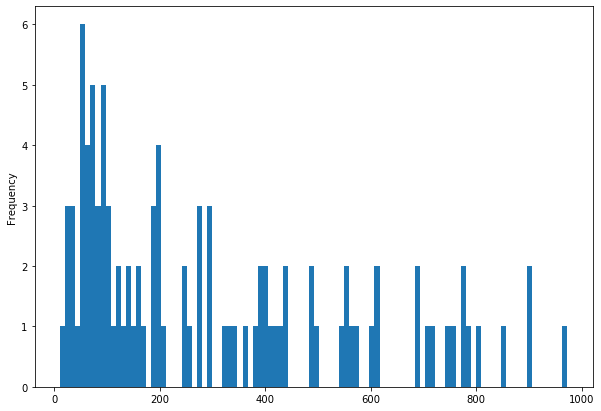

In [5]:
dlikes=dtst['likes']
dlikes.plot.hist(by=None, bins=100, figsize = (10,7))

In [10]:
# set number of clusters
kclusters = 3

dtst_clustering=dtst.drop('venue.name',1)
dtst_clustering=dtst_clustering.drop('venue.id',1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(dtst_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

dtst.insert(0, 'Cluster Labels', kmeans.labels_)

ValueError: cannot insert Cluster Labels, already exists

In [16]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dtst['venue.location.lat'],dtst['venue.location.lng'], dtst['venue.name'],dtst['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters




In [17]:
dtst.sort_values(by=['Cluster Labels'])

,Cluster Labels,venue.id,venue.name,venue.location.lat,venue.location.lng,likes
49,0,4a8da189f964a520501020e3,Vito's Italian Deli,40.746401,-74.028310,77
30,0,4a0babaaf964a52007751fe3,Marea,40.767452,-73.981114,11
31,0,5a69ef1c8e886a7dd293e8f9,Boris & Horton,40.729142,-73.981333,99
73,0,4aa3ddbdf964a520354420e3,Anthony & Son Panini Shoppe,40.718091,-73.945009,198
33,0,584049fc4bafb7166110adb5,Post,40.722901,-73.982846,84
36,0,55d7c6bb498efa168c9483a9,Archestratus Books & Foods,40.732905,-73.955365,90
37,0,57a3bda338fa6612ad9c17f2,Secchu Yokota,40.722756,-73.983144,38
69,0,56055323498e16b73108b749,Lella Alimentari,40.715133,-73.946342,201
67,0,57d2eb6f498e9835421484d3,Dulce De Leche Bakery,40.747750,-74.048085,55
40,0,5cc4e9d0c876c8002c3010cb,Wayla,40.718291,-73.992584,126
